In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import datetime as dt

# 시각화 관련
import plotly_express as px
import plotly.figure_factory as ff
import cufflinks as cf
cf.go_offline(connected=True)
## cf.getThemes()
cf.set_config_file(theme='polar')
import plotly.graph_objects as go

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')
## plt.style.use("fivethirtyeight")
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.figsize"] = (10,6)


## 퀀트함수
from quant_functions import anal_funcs, data_funcs
from fredapi import Fred
fred = Fred(api_key='cfb4f49f5c1a9396f671b8049d992e56')

In [2]:
## 그리기 설정값
color_basic = "#3b4a6b" # 네이비 기본색
color_norm = "#f23557" # 진홍색 강조색
color_cont = "#22b2da" # 청록 대비색
color_cont2 = "#0095d9" # 짙은 청색
color_cont3 = "#6a5acd" # 선명한 보라색
color_cont4 = "#c77dff" # 라벤더
color_sub = "#ff6f3c" # 주황색 보조색
color_around = "#6E6E6E" # 회색 주변색
color_around2 = "#E0E0E0" # 밝은 회색 주변색

figsize=(12, 8)

In [3]:
# 블루 - 퍼플 테마
colors = [color_cont, color_cont2, color_cont3, color_cont4]
# LinearSegmentedColormap 생성
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

## EDA

##### Function

In [ ]:
## 주요 이평선 ## 피보나치
def get_signals(df, target):
    dataset = df[[target]].copy()
    dataset['M20'] = dataset[target].rolling(20).mean()
    dataset['M60'] = dataset[target].rolling(60).mean()
    dataset['M120'] = dataset[target].rolling(120).mean()
    dataset['M200'] = dataset[target].rolling(200).mean()
    dataset['M500'] = dataset[target].rolling(500).mean()

    ## dataset['D10'] = dataset[target].max() * (1-.1)
    ## dataset['D20'] = dataset[target].max() * (1-.2)
    ## dataset['D30'] = dataset[target].max() * (1-.3)
    dataset['F-4'] = dataset[target].max() * (1-0.6180339887498949)
    dataset['F-3'] = dataset[target].max() * (1-0.38196601125010515)
    dataset['F-2'] = dataset[target].max() * (1-0.2360679774997897)
    dataset['F-1'] = dataset[target].max() * (1-0.14589803375031546)
    
    return dataset

def percent_formatter(x, pos):
    return f"{int(x)}%"

##### Data

In [6]:
df = data_funcs.get_merged_df('^IXIC', '^GSPC', 'GC=F')
DGS20 = fred.get_series('DGS20')
DGS10 = fred.get_series('DGS10')
DGS2 = fred.get_series('DGS2')
DTB3 = fred.get_series('DTB3')
DFF = fred.get_series('DFF')
df = df.fillna(method = 'pad')

[*********************100%%**********************]  4 of 4 completed


In [74]:
rate_df = pd.DataFrame([DFF, DTB3, DGS2, DGS10, DGS20], index=['DFF', 'TB3M', 'GS2Y', 'GS10Y', 'GS20Y']).T.sort_index().fillna(method='pad')

In [81]:
## 분석 대상 지수
ticker = '^GSPC'

dataset = df.copy()
rate_data = rate_df.copy()
rate_data['T10Y3M'] = rate_data['GS10Y'] - rate_data['TB3M']
rate_data = rate_data.fillna(method='pad').dropna(subset=['GS10Y'])

In [77]:
## 경기침체와 MDD
mdd_df = dataset.copy()
srs = mdd_df[ticker]
def get_hp(srs):
    '''전고점 탐색 함수'''
    return [srs[:i+1].max() for i in range(len(srs))]
mdd_df['hp'] = get_hp(srs)
mdd_df['mdd'] = (mdd_df[ticker] - mdd_df['hp'])/mdd_df['hp']

mdd_df['경기침체'] = '정상'

mdd_df['경기침체']['1948-11-01':'1949-10-28'] = '세계전충격'
mdd_df['경기침체']['1953-07-01':'1954-05-28'] = '한국전충격'
mdd_df['경기침체']['1957-08-01':'1958-04-28'] = '아이젠하워리세션'
mdd_df['경기침체']['1960-04-01':'1961-02-28'] = '연착륙'
mdd_df['경기침체']['1969-12-01':'1970-10-29'] = '달러위기'
mdd_df['경기침체']['1973-11-05':'1975-03-03'] = '1차오일쇼크'
mdd_df['경기침체']['1980-01-02':'1980-07-02'] = '2차오일쇼크'
mdd_df['경기침체']['1981-07-01':'1982-11-03'] = '물가충격'
mdd_df['경기침체']['1990-07-05':'1991-03-01'] = '걸프전'
mdd_df['경기침체']['2001-03-02':'2001-11-02'] = '닷컴버블'
mdd_df['경기침체']['2007-12-04':'2009-06-01'] = '금융위기'
mdd_df['경기침체']['2020-01-31':'2020-04-03'] = '코로나'

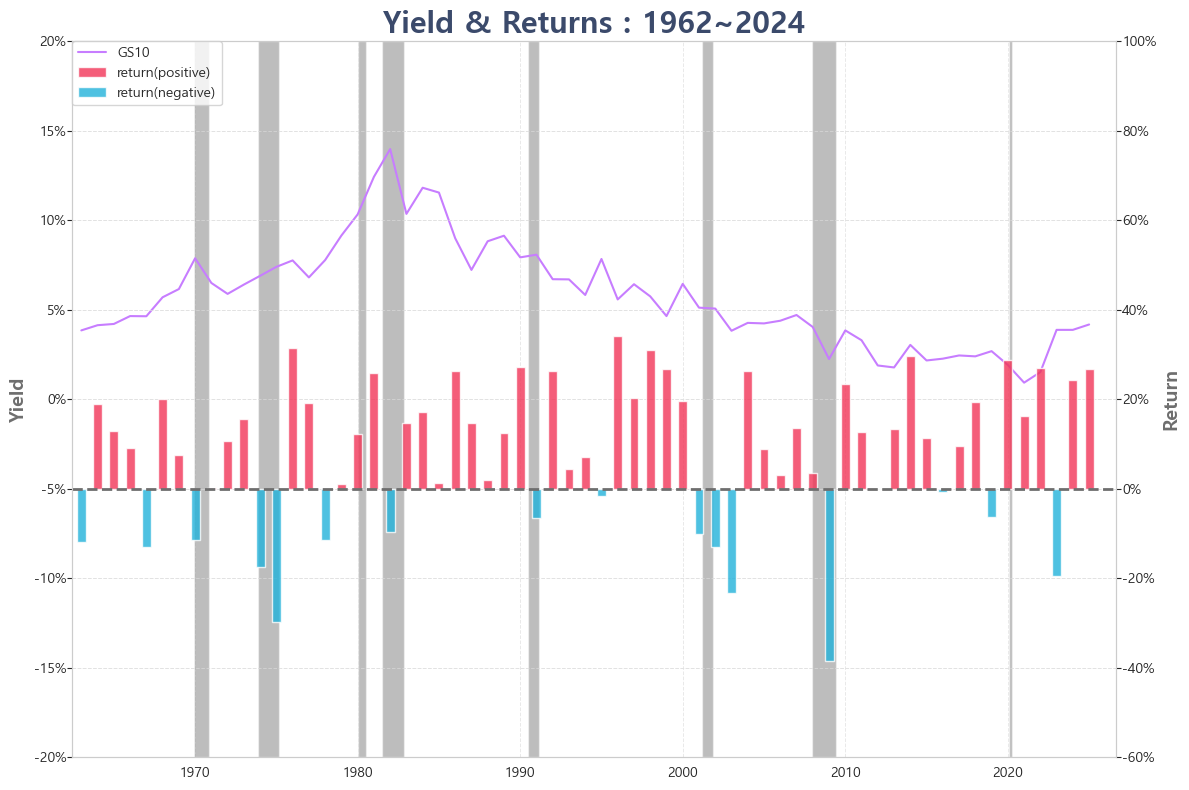

In [87]:
data = dataset.copy()

data['GS10'] = rate_data['GS10Y'].copy()
data = data.fillna(method='pad')

data = data.resample('Y').last()

data['return'] = data[ticker].pct_change()
data = data.dropna(subset=['GS10', 'return'])
data['return'] = data['return'] * 100

fig, ax1 = plt.subplots(figsize=figsize)

# GS10 데이터만 그리기
line2 = ax1.plot(data.index, data['GS10'],
                 color=color_cont4, label="GS10")
ax1.set_xlabel("")
ax1.set_ylabel("Yield", fontsize=14, fontweight="bold", color=color_around)
ax1.set_ylim([-20, 20])
ax1.set_xlim([min(data.index) - dt.timedelta(days=200),
              max(data.index) + dt.timedelta(days=600)])

plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))
plt.gca().tick_params(axis="y", pad=1)  # Y축 눈금 패딩 조정
plt.grid(color=color_around2, linestyle="--", linewidth=0.7, alpha=0.7)

# Return 데이터를 bar로 그리기
ax2 = ax1.twinx()
performance_plus = data['return'][data['return'] >= 0]
ax2.bar(performance_plus.index, performance_plus,
        color=color_norm, alpha=0.8, width=200, label="return(positive)")
performance_minus = data['return'][data['return'] < 0]
ax2.bar(performance_minus.index, performance_minus,
        color=color_cont, alpha=0.8, width=200, label="return(negative)")
ax2.axhline(0, color=color_around, linestyle='--', linewidth=2)
ax2.set_ylabel("Return", fontsize=14, fontweight="bold", color=color_around)
ax2.set_ylim([-60, 100])

plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))
plt.gca().tick_params(axis="y", pad=1)  # Y축 눈금 패딩 조정
plt.grid(color=color_around2, linestyle="--", linewidth=0.7, alpha=0.7)

plt.title(f"Yield & Returns : {data.index.year[0]}~{data.index.year[-1]}", fontsize=22, fontweight='bold', color=color_basic)
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
ax2.legend(handler1 + handler2, label1 + label2, loc=2, borderaxespad=0.)


## 경기침체
# ax1.axvspan('1948-11-01', '1949-10-28', facecolor=color_around, alpha=0.45)
# ax1.axvspan('1953-07-01', '1954-05-28', facecolor=color_around, alpha=0.45)
# ax1.axvspan('1957-08-01', '1958-04-28', facecolor=color_around, alpha=0.45)
# ax1.axvspan('1960-04-01', '1961-02-28', facecolor=color_around, alpha=0.45)
ax1.axvspan('1969-12-01', '1970-10-29', facecolor=color_around, alpha=0.45)
ax1.axvspan('1973-11-05', '1975-03-03', facecolor=color_around, alpha=0.45)
ax1.axvspan('1980-01-02', '1980-07-02', facecolor=color_around, alpha=0.45)
ax1.axvspan('1981-07-01', '1982-11-03', facecolor=color_around, alpha=0.45)
ax1.axvspan('1990-07-05', '1991-03-01', facecolor=color_around, alpha=0.45)
ax1.axvspan('2001-03-02', '2001-11-02', facecolor=color_around, alpha=0.45)
ax1.axvspan('2007-12-04', '2009-06-01', facecolor=color_around, alpha=0.45)
ax1.axvspan('2020-01-31', '2020-04-03', facecolor=color_around, alpha=0.45)
## ax1.axvspan('2023-09-01', '2024-03-31', facecolor=color_around, alpha=0.45)

plt.tight_layout()
plt.show()

In [ ]:
_df = return_df_type7[['SCHD', '6:4', 'TLT']].copy().reset_index()
_df = _df.melt(id_vars='index', value_vars=_df.columns, var_name='Ticker', value_name='Value')

plt.figure(figsize=figsize)
colors = [color_norm, color_sub, color_cont]
lineplot = sns.lineplot(data=_df, x='index', y='Value', hue='Ticker', palette=colors, linestyle='-', linewidth=2)
plt.title(f'5-Year Rolling Returns : {dataset_imputed_small.index[0].year}~{dataset_imputed_small.index[-1].year}', fontsize=22, fontweight='bold', color=color_basic)
plt.ylabel("Return", fontsize=14, labelpad=-40, fontweight="bold", color=color_around, loc="top", rotation=0)
plt.xlabel("")
plt.xticks(fontsize=12, color=color_around)
plt.yticks(fontsize=12, color=color_around)


# % 단위를 추가하는 포맷터 함수 정의
def percent_formatter(x, pos):
    return f"{int(x)}%"
# X축, Y축에 % 포맷터 적용
plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))
# 눈금과 축 간격 줄이기
plt.gca().tick_params(axis="y", pad=1)  # Y축 눈금 패딩 조정

plt.axvspan('2001-03-02', '2001-11-02', facecolor='gray', alpha=0.45)
plt.axvspan('2007-12-04', '2009-06-01', facecolor='gray', alpha=0.45)

# 그리드 추가
plt.grid(color=color_around2, linestyle="--", linewidth=0.7, alpha=0.7)

# 그래프 표시
plt.tight_layout()
plt.show()